In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
train_df = pd.read_csv(
    'train-wrangled2.csv',
    index_col=0,
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
train_df.shape

(903653, 35)

In [79]:
test_df = pd.read_csv(
    'test-wrangled2.csv',
    index_col=0,
    dtype={
        'fullVisitorId': 'str',
        'trafficSource.campaignCode': 'str',
        'visitId': 'str'
    },
    parse_dates=['date'])
test_df.shape

(804684, 34)

In [80]:
categorical = train_df.drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId', 'totals.transactionRevenue'
])
numerical = categorical.copy()
categorical = categorical.select_dtypes('object').columns
numerical = numerical.select_dtypes('number').columns

print('Categorical features: ' + str(len(categorical)))
print('Numerical features: ' + str(len(numerical)))

Categorical features: 22
Numerical features: 7


In [81]:
train_df[numerical].dtypes

visitNumber                              int64
visitStartTime                           int64
totals.bounces                         float64
totals.hits                              int64
totals.newVisits                       float64
totals.pageviews                       float64
trafficSource.adwordsClickInfo.page    float64
dtype: object

In [82]:
other = list(set(train_df.columns) - set(categorical) - set(numerical))
train_df[other].dtypes

totals.transactionRevenue           float64
sessionId                            object
device.isMobile                        bool
date                         datetime64[ns]
fullVisitorId                        object
visitId                              object
dtype: object

In [83]:
train_df.loc[:, categorical] = train_df[categorical].fillna('unknown')
test_df.loc[:, categorical] = test_df.loc[:, categorical].fillna('unknown')
train_df.loc[:,'totals.transactionRevenue'].fillna(0, inplace=True)

## Feature engineering

In [84]:
train_df[
    'hits/pageview'] = train_df['totals.hits'] / train_df['totals.pageviews']
test_df[
    'hits/pageview'] = test_df['totals.hits'] / test_df['totals.pageviews']

In [71]:
encoder = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in categorical:
    encoder.fit(train_df.append(test_df, sort=False)[col].astype('str'))
    # Transform both training and testing data
    train_df[col] = encoder.transform(train_df[col].astype('str'))
    test_df[col] = encoder.transform(test_df[col].astype('str'))
    
    # Keep track of how many columns were label encoded
    le_count += 1
            
print('%d columns were label encoded.' % le_count)

22 columns were label encoded.


In [8]:
first_date =  train_df['date'][0]
train_df['date'] = (train_df['date'] - first_date).dt.days
test_df['date'] = (test_df['date'] - first_date).dt.days

In [33]:
threshold = int(train_df.shape[0] * 0.8)
X = train_df.drop(columns=[
    'fullVisitorId', 'sessionId', 'visitId', 'totals.transactionRevenue'
])
y = np.log1p(train_df['totals.transactionRevenue'])
X_train = X.loc[:threshold]
y_train = y[:threshold+1]
X_val = X.loc[threshold:]
y_val = y[threshold:]
X_test = test_df.drop(columns=['fullVisitorId', 'sessionId', 'visitId'])

In [36]:
def train_model(X_train,
                   y_train,
                   eval_set = None,
                   n_estimators=1000,
                   early_stopping_rounds=100):

    reg = lgb.LGBMRegressor(
        boosting_type='gbdt',
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.02,
        n_estimators=n_estimators,
        subsample_for_bin=200000,
        objective='regression',
        class_weight=None,
        min_split_gain=0.0,
        min_child_weight=0.001,
        min_child_samples=20,
        subsample=1.0,
        subsample_freq=0,
        colsample_bytree=1.0,
        reg_alpha=0.0,
        reg_lambda=0.0,
        random_state=42,
        n_jobs=-1,
        silent=False,
        importance_type='split')

    reg.fit(
        X=X_train,
        y=y_train,
        sample_weight=None,
        init_score=None,
        eval_set=eval_set,
        eval_names=None,
        eval_sample_weight=None,
        eval_init_score=None,
        eval_metric='rmse',
        early_stopping_rounds=early_stopping_rounds,
        verbose=1,
        feature_name='auto',
        categorical_feature='auto',
        callbacks=None)

    print('best iteration: ' + str(reg.best_iteration_))
    print('best score: ' + str(reg.best_score_))

    return reg

In [37]:
model = train_model(X_train, y_train, [(X_val, y_val)])

[1]	valid_0's rmse: 1.99425
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.98261
[3]	valid_0's rmse: 1.97127
[4]	valid_0's rmse: 1.96028
[5]	valid_0's rmse: 1.94956
[6]	valid_0's rmse: 1.93919
[7]	valid_0's rmse: 1.92947
[8]	valid_0's rmse: 1.91984
[9]	valid_0's rmse: 1.91067
[10]	valid_0's rmse: 1.9017
[11]	valid_0's rmse: 1.89305
[12]	valid_0's rmse: 1.88463
[13]	valid_0's rmse: 1.87657
[14]	valid_0's rmse: 1.86854
[15]	valid_0's rmse: 1.86094
[16]	valid_0's rmse: 1.85368
[17]	valid_0's rmse: 1.84657
[18]	valid_0's rmse: 1.83992
[19]	valid_0's rmse: 1.83306
[20]	valid_0's rmse: 1.82683
[21]	valid_0's rmse: 1.82046
[22]	valid_0's rmse: 1.8144
[23]	valid_0's rmse: 1.8086
[24]	valid_0's rmse: 1.80296
[25]	valid_0's rmse: 1.79739
[26]	valid_0's rmse: 1.79215
[27]	valid_0's rmse: 1.78706
[28]	valid_0's rmse: 1.78218
[29]	valid_0's rmse: 1.7774
[30]	valid_0's rmse: 1.77262
[31]	valid_0's rmse: 1.7681
[32]	valid_0's rmse: 1.76377
[33]	valid_0's rmse: 1.

[280]	valid_0's rmse: 1.62098
[281]	valid_0's rmse: 1.62092
[282]	valid_0's rmse: 1.62088
[283]	valid_0's rmse: 1.62084
[284]	valid_0's rmse: 1.62085
[285]	valid_0's rmse: 1.62079
[286]	valid_0's rmse: 1.62071
[287]	valid_0's rmse: 1.62069
[288]	valid_0's rmse: 1.62067
[289]	valid_0's rmse: 1.62067
[290]	valid_0's rmse: 1.62063
[291]	valid_0's rmse: 1.62059
[292]	valid_0's rmse: 1.62054
[293]	valid_0's rmse: 1.62052
[294]	valid_0's rmse: 1.62053
[295]	valid_0's rmse: 1.62048
[296]	valid_0's rmse: 1.62045
[297]	valid_0's rmse: 1.62035
[298]	valid_0's rmse: 1.62036
[299]	valid_0's rmse: 1.62032
[300]	valid_0's rmse: 1.62033
[301]	valid_0's rmse: 1.62033
[302]	valid_0's rmse: 1.62026
[303]	valid_0's rmse: 1.62023
[304]	valid_0's rmse: 1.62024
[305]	valid_0's rmse: 1.62025
[306]	valid_0's rmse: 1.62017
[307]	valid_0's rmse: 1.62011
[308]	valid_0's rmse: 1.6201
[309]	valid_0's rmse: 1.6201
[310]	valid_0's rmse: 1.62011
[311]	valid_0's rmse: 1.62014
[312]	valid_0's rmse: 1.62013
[313]	valid_

[561]	valid_0's rmse: 1.6164
[562]	valid_0's rmse: 1.6164
[563]	valid_0's rmse: 1.61638
[564]	valid_0's rmse: 1.61641
[565]	valid_0's rmse: 1.61639
[566]	valid_0's rmse: 1.6164
[567]	valid_0's rmse: 1.61642
[568]	valid_0's rmse: 1.61638
[569]	valid_0's rmse: 1.61638
[570]	valid_0's rmse: 1.6164
[571]	valid_0's rmse: 1.6164
[572]	valid_0's rmse: 1.61643
[573]	valid_0's rmse: 1.61639
[574]	valid_0's rmse: 1.61641
[575]	valid_0's rmse: 1.6164
[576]	valid_0's rmse: 1.61637
[577]	valid_0's rmse: 1.61637
[578]	valid_0's rmse: 1.61637
[579]	valid_0's rmse: 1.61636
[580]	valid_0's rmse: 1.61637
[581]	valid_0's rmse: 1.61635
[582]	valid_0's rmse: 1.61638
[583]	valid_0's rmse: 1.61638
[584]	valid_0's rmse: 1.6164
[585]	valid_0's rmse: 1.61639
[586]	valid_0's rmse: 1.61636
[587]	valid_0's rmse: 1.61635
[588]	valid_0's rmse: 1.61634
[589]	valid_0's rmse: 1.61633
[590]	valid_0's rmse: 1.61628
[591]	valid_0's rmse: 1.61629
[592]	valid_0's rmse: 1.61625
[593]	valid_0's rmse: 1.61623
[594]	valid_0's r

In [38]:
def prediction(model, X, y):
    pred = model.predict(X, num_iteration=model.best_iteration_)
    pred[pred < 0] = 0
    df = train_df.loc[X.index, ['fullVisitorId']]
    df['real'] = np.expm1(y)
    df['predicted'] = np.expm1(pred)
    df = df.groupby('fullVisitorId').sum()
    df['predicted'] = np.log1p(df["predicted"])
    df['real'] = np.log1p(df['real'])
        
    return df

In [39]:
def scoring(model, X, y, operation):
    df = prediction(model, X, y)
    print(operation + ' error: ' +
          str(np.sqrt(mean_squared_error(df['predicted'], df['real']))))

In [40]:
scoring(model, X_train, y_train, 'Training')
scoring(model, X_val, y_val, 'Validation')

Training error: 1.5116147406771236
Validation error: 1.643766984830285


1.4541 on LB

In [50]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_,
    }).sort_values(
    'Importance', ascending=False)
importance_df

Feature  Importance
31                                 hits/pageview        3400
1                                           date        2757
18                              totals.pageviews        2708
16                                   totals.hits        2171
2                                    visitNumber        1714
12                      geoNetwork.networkDomain        1174
3                                 visitStartTime        1153
8                                geoNetwork.city        1048
7                         device.operatingSystem         741
13                             geoNetwork.region         710
10                            geoNetwork.country         642
11                              geoNetwork.metro         623
29                    trafficSource.referralPath         441
26                    trafficSource.isTrueDirect         387
30                          trafficSource.source         305
27                         trafficSource.keyword         255
0                                channelGrouping         254
5                          device.deviceCategory         219
9                           geoNetwork.continent         214
4                                 device.browser         194
6                                device.isMobile         185
28                          trafficSource.medium         184
21          trafficSource.adwordsClickInfo.gclId         131
14                       geoNetwork.subContinent          48
20  trafficSource.adwordsClickInfo.adNetworkType          14
19                       trafficSource.adContent          12
17                              totals.newVisits           3
25                        trafficSource.campaign           3
22      trafficSource.adwordsClickInfo.isVideoAd           0
23           trafficSource.adwordsClickInfo.page           0
24           trafficSource.adwordsClickInfo.slot           0
15                                totals.bounces           0

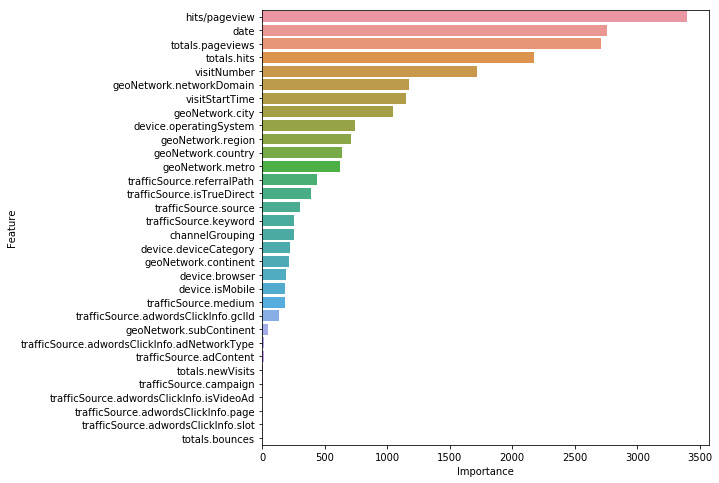

In [41]:
plt.figure(figsize=(8, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')

In [57]:
columns = importance_df.loc[importance_df['Importance'] > 0, 'Feature']

model = train_model(X_train[columns], y_train,
                    [(X_val[columns], y_val)])

[1]	valid_0's rmse: 1.99425
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.98261
[3]	valid_0's rmse: 1.97127
[4]	valid_0's rmse: 1.96028
[5]	valid_0's rmse: 1.94956
[6]	valid_0's rmse: 1.93919
[7]	valid_0's rmse: 1.92947
[8]	valid_0's rmse: 1.91984
[9]	valid_0's rmse: 1.91067
[10]	valid_0's rmse: 1.9017
[11]	valid_0's rmse: 1.89305
[12]	valid_0's rmse: 1.88463
[13]	valid_0's rmse: 1.87657
[14]	valid_0's rmse: 1.86854
[15]	valid_0's rmse: 1.86094
[16]	valid_0's rmse: 1.85368
[17]	valid_0's rmse: 1.84657
[18]	valid_0's rmse: 1.83992
[19]	valid_0's rmse: 1.83306
[20]	valid_0's rmse: 1.82683
[21]	valid_0's rmse: 1.82046
[22]	valid_0's rmse: 1.8144
[23]	valid_0's rmse: 1.8086
[24]	valid_0's rmse: 1.80296
[25]	valid_0's rmse: 1.79739
[26]	valid_0's rmse: 1.79215
[27]	valid_0's rmse: 1.78706
[28]	valid_0's rmse: 1.78218
[29]	valid_0's rmse: 1.7774
[30]	valid_0's rmse: 1.77262
[31]	valid_0's rmse: 1.7681
[32]	valid_0's rmse: 1.76377
[33]	valid_0's rmse: 1.

[279]	valid_0's rmse: 1.62095
[280]	valid_0's rmse: 1.62095
[281]	valid_0's rmse: 1.6209
[282]	valid_0's rmse: 1.62085
[283]	valid_0's rmse: 1.62082
[284]	valid_0's rmse: 1.62082
[285]	valid_0's rmse: 1.62076
[286]	valid_0's rmse: 1.62068
[287]	valid_0's rmse: 1.62066
[288]	valid_0's rmse: 1.62065
[289]	valid_0's rmse: 1.62064
[290]	valid_0's rmse: 1.6206
[291]	valid_0's rmse: 1.62057
[292]	valid_0's rmse: 1.62051
[293]	valid_0's rmse: 1.62049
[294]	valid_0's rmse: 1.6205
[295]	valid_0's rmse: 1.62046
[296]	valid_0's rmse: 1.62042
[297]	valid_0's rmse: 1.62033
[298]	valid_0's rmse: 1.62033
[299]	valid_0's rmse: 1.6203
[300]	valid_0's rmse: 1.6203
[301]	valid_0's rmse: 1.6203
[302]	valid_0's rmse: 1.62023
[303]	valid_0's rmse: 1.6202
[304]	valid_0's rmse: 1.62021
[305]	valid_0's rmse: 1.62023
[306]	valid_0's rmse: 1.62014
[307]	valid_0's rmse: 1.62008
[308]	valid_0's rmse: 1.62007
[309]	valid_0's rmse: 1.62007
[310]	valid_0's rmse: 1.62009
[311]	valid_0's rmse: 1.62012
[312]	valid_0's r

[561]	valid_0's rmse: 1.61634
[562]	valid_0's rmse: 1.61634
[563]	valid_0's rmse: 1.61632
[564]	valid_0's rmse: 1.61635
[565]	valid_0's rmse: 1.61633
[566]	valid_0's rmse: 1.61634
[567]	valid_0's rmse: 1.61635
[568]	valid_0's rmse: 1.61632
[569]	valid_0's rmse: 1.61632
[570]	valid_0's rmse: 1.61633
[571]	valid_0's rmse: 1.61634
[572]	valid_0's rmse: 1.61636
[573]	valid_0's rmse: 1.61633
[574]	valid_0's rmse: 1.61635
[575]	valid_0's rmse: 1.61634
[576]	valid_0's rmse: 1.61631
[577]	valid_0's rmse: 1.6163
[578]	valid_0's rmse: 1.6163
[579]	valid_0's rmse: 1.6163
[580]	valid_0's rmse: 1.6163
[581]	valid_0's rmse: 1.61629
[582]	valid_0's rmse: 1.61631
[583]	valid_0's rmse: 1.61632
[584]	valid_0's rmse: 1.61633
[585]	valid_0's rmse: 1.61632
[586]	valid_0's rmse: 1.61629
[587]	valid_0's rmse: 1.61629
[588]	valid_0's rmse: 1.61628
[589]	valid_0's rmse: 1.61626
[590]	valid_0's rmse: 1.61622
[591]	valid_0's rmse: 1.61623
[592]	valid_0's rmse: 1.61618
[593]	valid_0's rmse: 1.61616
[594]	valid_0'

In [59]:
scoring(model, X_train[columns], y_train, 'Training')
scoring(model, X_val[columns], y_val, 'Validation')

Training error: 1.5116147406771236
Validation error: 1.6437090647533557


## Train on the full dataset

In [60]:
final_model = train_model(
    X[columns],
    y,
    early_stopping_rounds=None,
    n_estimators=model.best_iteration_)

best iteration: None
best score: defaultdict(<class 'dict'>, {})


In [62]:
result = final_model.predict(X_test[columns])
result[result < 0] = 0
result_df = test_df[['fullVisitorId']]
result_df['PredictedLogRevenue'] = np.expm1(result)
result_df = result_df.groupby('fullVisitorId', as_index=False).sum()
result_df['PredictedLogRevenue'] = np.log1p(result_df['PredictedLogRevenue'])

/home/yannis/miniconda3/envs/ga/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [63]:
result_df.to_csv('submission(lgbm-label encoding+FE+FS).csv', index=False)

1.4489 on LB (with categories 1.4502)